# Asset Allocation

In [1]:
%load_ext autoreload
%autoreload 2
import os
import gym
import time
import threading
import numpy as np
import ipywidgets as widgets
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

# to save renderings
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
plotly.io.orca.config.executable = '/opt/anaconda3/bin/orca'

dimensions = [
    [1920, 1200],
    [1024, 674]
]
dim = dimensions[1]

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import layers

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.enable_eager_execution(config=config)

if not os.path.exists('images'):
    os.mkdir('images')

## Defining a Security

In [7]:
class Security:
    def __init__(self, mu, sigma, init_price=1.):
        self.mu = mu
        self.sigma = sigma
        self.price = init_price
        
    def step(self, state=None):
        # TODO: price as a function of state
        change = 1
        if state is None:
            change = np.random.normal(self.mu, self.sigma)
        self.price *= (1. + change)
        return change

In [8]:
sec = Security(0, 0.1)
sec.step()

0.023308173585788336

In [9]:
plot_data = []
for sec in range(10):
    sec = Security(0.005, 0.02)
    data = []
    T = 100

    for t in range(T):
        p = sec.step()
        data.append(sec.price)
        
    plot_data.append(go.Scatter(x=np.arange(T), y=data))
    
go.FigureWidget(
    data=plot_data,
    layout=go.Layout(
        yaxis=dict(
            range=(0.,2.5)
        )
    )
)

FigureWidget({
    'data': [{'type': 'scatter',
              'uid': '11315cef-1528-4956-a146-879c7795f6c2',
 …

## Security Based Environment

In [10]:
class AllocationEnv(gym.Env):
    metadata = { 'render.modes': ['human'] }
    
    def __init__(self, mu=0.0, sigma=0.0, init_capital=1., episode_length=100):
        self.mu = mu
        self.sigma = sigma
        self.init_capital = init_capital
        self.episode_length = episode_length
        self.security = None
        
    def set_params(self, mu=None, sigma=None):
        if mu is not None:
            self.mu = mu
            self.security.mu = mu
        if sigma is not None:
            self.sigma = sigma
            self.security.sigma = sigma
        
    def reset(self):
        self.t = 0 # timestep
        self.c = self.init_capital # capital
        self.security = Security(self.mu, self.sigma)
        self.state = [self.security.price, self.mu, self.sigma]
        return np.array(self.state)
    
    def step(self, allocation):
        change = self.security.step()
        reward = change * allocation
        self.c *= (1 + reward)
        self.state = [self.security.price, self.mu, self.sigma]
        self.t += 1
        done = self.t >= self.episode_length or self.c <= 0
        info = { 'c': self.c, 't': self.t, 'price': self.security.price }
        return np.array(self.state), reward, done, info
        
    def render(self, mode='human'):
        pass

## Running Agents

In [12]:
def get_rate_plots(xs, cs, us):
    x_fig = go.FigureWidget(
        data=[go.Scatter(x=np.arange(len(xs)), y=xs)],
        layout=go.Layout(
            title="Rate",
            template="presentation",
            xaxis=dict(
                title='t'
            ),
            yaxis=dict(
                title='Rate (x)'
            )
        )
    )

    c_fig = go.FigureWidget(
        data=[go.Scatter(x=np.arange(len(cs)), y=cs)],
        layout=go.Layout(
            title="Captial",
            template="presentation",
            xaxis=dict(
                title='t'
            ),
            yaxis=dict(
                title='Capital (c)'
            )
        )
    )

    u_fig = go.FigureWidget(
        data=[go.Scatter(x=np.arange(len(us)), y=us)],
        layout=go.Layout(
            title="Allocation",
            template="presentation",
            xaxis=dict(
                title='t'
            ),
            yaxis=dict(
                title='Allocation'
            )
        )
    )

    fig = widgets.VBox(
        [x_fig, c_fig, u_fig]
    )
    
    return fig

class RandomAgent:
    def __init__(self):
        pass
    
    def step(self, obs):
        return np.random.rand()

env = AllocationEnv(0.001, 0.001)
agent = RandomAgent()

xs = []
cs = []
us = []

done = False
obs = env.reset()
while not done:
    xs.append(obs[0])
    action = agent.step(obs)
    us.append(action)
    obs, reward, done, info = env.step(action)
    cs.append(info['c'])
    
get_rate_plots(xs, cs, us)

    'data': [{'type': 'scatter',
              'uid': 'e5e8de46-3546-4836-b2e5-8…

In [13]:
def generate_sine(T, amp, fq, phs):
    afq = 2 * np.pi * fq
    return amp * np.sin(afq * np.arange(T) + phs)

T = 100
amp = 0.01
fq = 2/T
phs = 0
go.FigureWidget([go.Scatter(y=generate_sine(T, amp, fq, phs) + amp)])

FigureWidget({
    'data': [{'type': 'scatter',
              'uid': 'aa578e57-2314-4364-9219-f7e3eddb0e10',
 …

# Generate Training Data

In [14]:
T = 100

profit_val = generate_sine(T=T, amp=0.001, fq=2/T, phs=np.pi) - 0.0005
risk_val = np.abs(generate_sine(T=T, amp=0.01, fq=7/T, phs=np.pi/7) + 0.04)

max_mu = np.max(profit_val)
max_sigma = np.max(risk_val)

profit_fig = go.FigureWidget(
    data=[go.Scatter(x=np.arange(len(profit_val)), y=profit_val)],
    layout=go.Layout(
        title="$\mu$",
        template="presentation",
        xaxis=dict(
            title='t'
        ),
        yaxis=dict(
            title='$\mu$'
        )
    )
)

risk_fig = go.FigureWidget(
    data=[go.Scatter(x=np.arange(len(risk_val)), y=risk_val)],
    layout=go.Layout(
        title="$\sigma$",
        template="presentation",
        xaxis=dict(
            title='t'
        ),
        yaxis=dict(
            title='$\sigma$'
        )
    )
)

profit_sent = profit_val/max_mu
risk_sent = (max_sigma - risk_val)/max_sigma

alloc = profit_sent# * (risk_sent * sigma_coef)
mu_coef = 2.
tolerance = 0.2
print(f"tolerance: {tolerance}")
print(f"mu coef: {mu_coef}")
alloc += tolerance
alloc *= mu_coef
alloc = np.min([alloc, np.ones_like(alloc)], axis=0)

alloc_fig = go.FigureWidget(
    data=[go.Scatter(x=np.arange(len(alloc)), y=np.max([alloc, np.zeros_like(alloc)], axis=0))],
    layout=go.Layout(
        title="Allocation",
        template="presentation",
        xaxis=dict(
            title='t'
        ),
        yaxis=dict(
            title='Allocation',
            range=(-0.1, 1.1)
        )
    )
)

fig = widgets.VBox(
        [profit_fig, risk_fig, alloc_fig]
    )
fig

tolerance: 0.2
mu coef: 2.0


    'data': [{'type': 'scatter',
              'uid': '99bbd97b-47ea-4776-a7ec-9…

In [15]:
class InsiderAgent:
    def __init__(self, max_mu, mu_coef=1., tolerance=1.):
        self.max_mu = max_mu
        self.mu_coef = mu_coef
        self.tolerance = tolerance
    
    def step(self, obs):
        price = obs[0]
        mu = obs[1]
        sigma = obs[2]
        profit_sent = mu/self.max_mu
        alloc = (profit_sent + self.tolerance)
        alloc *= self.mu_coef
        return np.min([np.max([alloc, 0]), 1])

env = AllocationEnv()
agent = InsiderAgent(
    max_mu=max_mu,
    mu_coef=mu_coef,
    tolerance=tolerance
)

xs = []
cs = []
us = []

done = False
obs = env.reset()
t = 0
while not done:
    xs.append(obs[0])
    action = agent.step(obs)
    us.append(action)
    obs, reward, done, info = env.step(action)
    cs.append(info['c'])
    env.set_params(mu=profit_val[t], sigma=risk_val[t])
    t += 1
    
get_rate_plots(xs, cs, us)

    'data': [{'type': 'scatter',
              'uid': '619984db-deab-46ca-a9ae-e…

# Testing our Agent over Multiple Episodes

In [16]:
def run_episode(episodes, env, agent):
    capitals = []
    rates = []
    for episode in range(episodes):
        done = False
        obs = env.reset()
        t = 0
        cs = []
        rs = []
        while not done:
            action = agent.step(obs)
            obs, reward, done, info = env.step(action)
            cs.append(info['c'])
            rs.append(info['price'])
            env.set_params(mu=profit_val[t], sigma=risk_val[t])
            t += 1

        capitals.append(info['c'])
        rates.append(info['price'])
        
    return capitals, rates

env = AllocationEnv()
agent = InsiderAgent(
    max_mu=max_mu,
    mu_coef=mu_coef,
    tolerance=tolerance
)

episodes = 1000
capitals, rates = run_episode(episodes, env, agent)

print(f"Episodes:     {episodes}")
print(f"Mean Rate:    {np.mean(rates)}")
print(f"Mean Capital: {np.mean(capitals)}")

go.FigureWidget(
    data=[
        go.Scatter(x=np.arange(len(rates)), y=rates, name='Final Rate'),
        go.Scatter(x=np.arange(len(capitals)), y=capitals, name='Final Capital'),
        go.Scatter(x=np.arange(len(rates)), y=np.ones_like(rates), name='Riskless Rate')
    ],
    layout=go.Layout(
        title="$\mu$",
        template="presentation",
        xaxis=dict(
            title='t'
        ),
        yaxis=dict(
            title='$\mu$'
        )
    )
)

Episodes:     1000
Mean Rate:    0.9590322556662907
Mean Capital: 1.0136140261490576


FigureWidget({
    'data': [{'name': 'Final Rate',
              'type': 'scatter',
              'uid': '0e2f…

## Training Session

In [17]:
def run_episode(episodes, env, agent):
    capitals = []
    rates = []
    for episode in range(episodes):
        done = False
        obs = env.reset()
        t = 0
        cs = []
        rs = []
        while not done:
            action = agent.step(obs)
            obs, reward, done, info = env.step(action)
            cs.append(info['c'])
            rs.append(info['price'])
            env.set_params(mu=profit_val[t], sigma=risk_val[t])
            t += 1

        capitals.append(info['c'])
        rates.append(info['price'])
    return capitals, rates

coef_dim = 10
coef_space = np.linspace(0, 2, coef_dim)
cap_space = np.empty((coef_dim, coef_dim))
for idx, mu_coef in enumerate(coef_space):
    print(idx, end=', ')
    for idy, tol in enumerate(coef_space):
        env = AllocationEnv()
        agent = InsiderAgent(
            max_mu=max_mu,
            mu_coef=mu_coef,
            tolerance=tol
        )

        episodes = 100
        capitals, rates = run_episode(episodes, env, agent)
        cap_space[idx, idy] = np.mean(capitals)
        
# Plot
go.FigureWidget(
    data=[
        go.Heatmap(
            x=coef_space,
            y=coef_space,
            z=cap_space,
            zsmooth='best'
        )
    ],
    layout=go.Layout(
        title="Average Returns",
        template="presentation",
        xaxis=dict(
            title='$\mu$'
        ),
        yaxis=dict(
            title='tolerance'
        ),
        width=500,
        height=500
    )
)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

FigureWidget({
    'data': [{'type': 'heatmap',
              'uid': 'b41f29c4-d4e4-4e52-9d59-cdb3310d697d',
 …

#### Setup Parallel Processing

In [18]:
import multiprocessing as mp
import sqlalchemy as db
import pandas as pd
import time

engine = db.create_engine('sqlite:///data.sqlite')
connection = engine.connect()
metadata = db.MetaData()

episode_table = db.Table(
    'episode', metadata,
    db.Column('id', db.Integer(), primary_key=True),
    db.Column('session', db.Integer(), nullable=False),
    db.Column('idx', db.Float(), nullable=False),
    db.Column('idy', db.Float(), nullable=False),
    db.Column('capital', db.Float(), nullable=False),
    db.Column('std', db.Float(), nullable=False)
)

metadata.create_all(engine)

#### Execute Parallel Jobs

In [19]:
def episode_worker(session, episodes, args):
    env = AllocationEnv()
    agent = InsiderAgent(**args)
    capitals, rates = run_episode(episodes, env, agent)
    query = db.insert(episode_table).values(
        session=session,
        idx=args['mu_coef'],
        idy=args['tolerance'],
        capital=np.mean(capitals),
        std=np.std(capitals)
    )
    connection = engine.connect()
    connection.execute(query)
    connection.close()

# Create Process Jobs
coef_dim = 50
idx_space = np.linspace(1, 10, coef_dim)
idy_space = np.linspace(0, 2, coef_dim)
cap_space = np.empty((coef_dim, coef_dim))
jobs = []

last_session_id = connection.execute(
    db.select([db.func.max(episode_table.columns.session)])
).fetchone()[0]
if last_session_id is None:
    last_session_id = -1
session = last_session_id + 1
episodes = 25
for idx, mu_coef in enumerate(idx_space):
    for idy, tol in enumerate(idy_space):
        args = {
            'max_mu': max_mu,
            'mu_coef': mu_coef,
            'tolerance': tol
        }
        p = mp.Process(target=episode_worker, args=(session, episodes, args))
        jobs.append(p)
        
# Run Jobs
total_job_count = len(jobs)
running_jobs = []
completed_jobs = 0
max_parallel_runs = 20
start_time = time.time()
last_time = start_time
while completed_jobs < total_job_count:
    while len(running_jobs) < max_parallel_runs and len(jobs):
        p = jobs.pop()
        p.start()
        running_jobs.append(p)
        
    _running_jobs = []
    for job in running_jobs:
        if job.is_alive():
            _running_jobs.append(job)
        else:
            completed_jobs += 1
    running_jobs = _running_jobs
    
    # Logging
    current_time = time.time()
    if current_time - last_time > 1:
        print(f"{time.strftime('%c')}: Jobs Complete - {completed_jobs}/{total_job_count}")
        last_time = current_time
print(f"{time.strftime('%c')}: Jobs Complete - {completed_jobs}/{total_job_count}")

Sun Jul 28 19:30:23 2019: Jobs Complete - 72/2500
Sun Jul 28 19:30:24 2019: Jobs Complete - 153/2500
Sun Jul 28 19:30:25 2019: Jobs Complete - 234/2500
Sun Jul 28 19:30:27 2019: Jobs Complete - 313/2500
Sun Jul 28 19:30:28 2019: Jobs Complete - 394/2500
Sun Jul 28 19:30:29 2019: Jobs Complete - 476/2500
Sun Jul 28 19:30:30 2019: Jobs Complete - 554/2500
Sun Jul 28 19:30:31 2019: Jobs Complete - 635/2500
Sun Jul 28 19:30:32 2019: Jobs Complete - 716/2500
Sun Jul 28 19:30:33 2019: Jobs Complete - 795/2500
Sun Jul 28 19:30:34 2019: Jobs Complete - 871/2500
Sun Jul 28 19:30:35 2019: Jobs Complete - 950/2500
Sun Jul 28 19:30:36 2019: Jobs Complete - 1031/2500
Sun Jul 28 19:30:37 2019: Jobs Complete - 1112/2500
Sun Jul 28 19:30:38 2019: Jobs Complete - 1191/2500
Sun Jul 28 19:30:39 2019: Jobs Complete - 1271/2500
Sun Jul 28 19:30:40 2019: Jobs Complete - 1353/2500
Sun Jul 28 19:30:41 2019: Jobs Complete - 1433/2500
Sun Jul 28 19:30:42 2019: Jobs Complete - 1515/2500
Sun Jul 28 19:30:43 2019:

TypeError: object of type 'int' has no len()

#### Read Database into DataFrame and Plot

In [28]:
query = db.select([episode_table]).where(episode_table.columns.session == session)
result = connection.execute(query).fetchall()
df = pd.DataFrame(result, columns=episode_table.columns.keys())
print(df.describe())
df.head()

# Plot
go.FigureWidget(
    data=[
        go.Heatmap(
            x=df.idx,
            y=df.idy,
            z=df.capital,
            zmid=1.
        )
    ],
    layout=go.Layout(
        title="Average Returns",
        template="presentation",
        xaxis=dict(
            title='$\mu$'
        ),
        yaxis=dict(
            title='tolerance'
        ),
        width=500,
        height=500
    )
)

               id  session          idx          idy      capital          std
count  2500.00000   2500.0  2500.000000  2500.000000  2500.000000  2500.000000
mean   5765.50000      4.0     5.500000     1.000000     0.983575     0.282745
std     721.83216      0.0     2.651098     0.589133     0.019262     0.034000
min    4516.00000      4.0     1.000000     0.000000     0.939053     0.167201
25%    5140.75000      4.0     3.204082     0.489796     0.979378     0.262339
50%    5765.50000      4.0     5.500000     1.000000     0.987945     0.277656
75%    6390.25000      4.0     7.795918     1.510204     0.996198     0.309730
max    7015.00000      4.0    10.000000     2.000000     1.013757     0.364594


FigureWidget({
    'data': [{'type': 'heatmap',
              'uid': '6248884d-d725-419b-85d9-929a34631ef4',
 …

In [22]:
go.FigureWidget(
    data=[
        go.Heatmap(
            x=df.idx,
            y=df.idy,
            z=df['std']
        )
    ],
    layout=go.Layout(
        title="Standard Deviation",
        template="presentation",
        xaxis=dict(
            title='$\mu$'
        ),
        yaxis=dict(
            title='tolerance'
        ),
        width=500,
        height=500
    )
)

FigureWidget({
    'data': [{'type': 'heatmap',
              'uid': '35146cb1-3568-45e2-80ee-3a743d0804fc',
 …

## Learning Agent

In [29]:
class CriticModel(keras.Model):
    def __init__(self, observation_size, action_size):
        super(CriticModel, self).__init__()
        self.observation_size = observation_size
        self.action_size = action_size
        
        self.value_dense_1 = layers.Dense(128, activation='relu')
        self.value_dense_2 = layers.Dense(128, activation='relu')
        self.values = layers.Dense(1)

    def call(self, inputs):
        input_tensor = tf.convert_to_tensor(inputs, dtype=tf.float32)
        y = self.value_dense_1(input_tensor)
        y = self.value_dense_2(y)
        values = self.values(y)
        return values
    
class ActorModel(keras.Model):
    def __init__(self, observation_size, action_size):
        super(ActorModel, self).__init__()
        self.observation_size = observation_size
        self.action_size = action_size
        
        self.policy_dense_1 = layers.Dense(128, activation='relu')
        self.policy_dense_2 = layers.Dense(128, activation='relu')
        self.policy_logits = layers.Dense(action_size)

    def call(self, inputs):
        input_tensor = tf.convert_to_tensor(inputs, dtype=tf.float32)
        x = self.policy_dense_1(input_tensor)
        x = self.policy_dense_2(x)
        logits = self.policy_logits(x)
        return logits
    
class ActorCriticModel(keras.Model):
    def __init__(self, observation_size, action_size):
        super(ActorCriticModel, self).__init__()
        self.observation_size = observation_size
        self.action_size = action_size
        self.actor = ActorModel(observation_size, action_size)
        self.critic = CriticModel(observation_size, action_size)
        
    def call(self, inputs):
        return self.actor(inputs), self.critic(inputs)

class HyperParameters:
    def __init__(self, **kw):
        self.gamma = 0.99
        self.vf_coef = 0.5
        self.ent_coef = 0.01
        self.lr = 0.001
        self.__dict__.update(kw)
        
def discrete_loss(a2c, observations, actions, probabilities, discounted_rewards, hyperparameters, verbose=False, normalize_discounted_rewards=True, *args, **kargs):
    hp = hyperparameters
    
    logits, values = a2c(tf.convert_to_tensor(observations, dtype=tf.float32))
    values = tf.squeeze(values)

    if normalize_discounted_rewards:
        discounted_rewards -= np.mean(discounted_rewards)
        discounted_rewards /= np.std(discounted_rewards)

    discounted_rewards = tf.convert_to_tensor(np.array(discounted_rewards), dtype=tf.float32)
    advantages =  tf.stop_gradient(discounted_rewards) - values

    critic_loss = advantages ** 2

    policy = tf.nn.softmax(logits)
    entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=policy, logits=logits)

    actor_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=actions, logits=logits)
    actor_loss *= tf.stop_gradient(advantages)
    actor_loss -= hp.ent_coef * entropy

    total_loss = tf.reduce_mean(hp.vf_coef * critic_loss + actor_loss)

    if verbose:
        variables = dir()[:]
        for key in variables:
            print(key)
            print(locals()[key])
    
    return total_loss

def continuous_loss(a2c, observations, actions, probabilities, discounted_rewards, hyperparameters, verbose=False, normalize_discounted_rewards=True, *args, **kargs):
    hp = hyperparameters
    
    logits, values = a2c(tf.convert_to_tensor(observations, dtype=tf.float32))
    values = tf.squeeze(values)

    if normalize_discounted_rewards:
        discounted_rewards -= np.mean(discounted_rewards)
        discounted_rewards /= np.std(discounted_rewards)

    discounted_rewards = tf.convert_to_tensor(np.array(discounted_rewards), dtype=tf.float32)
    advantages =  tf.stop_gradient(discounted_rewards) - values

    critic_loss = advantages ** 2

    policy = tf.nn.softmax(logits)
    entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=policy, logits=logits)

    actor_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=actions, logits=logits)
    actor_loss *= tf.stop_gradient(advantages)
    actor_loss -= hp.ent_coef * entropy

    total_loss = tf.reduce_mean(hp.vf_coef * critic_loss + actor_loss)

    if verbose:
        variables = dir()[:]
        for key in variables:
            print(key)
            print(locals()[key])
    
    return total_loss

def run(env, a2c, verbose=False, *args, **kargs):
    obs = env.reset()
    done = False
    rewards = []
    actions = []
    probabilities = []
    observations = []
        
    while not done:
        logits, _ = a2c(tf.convert_to_tensor(obs[None, :], dtype=tf.float32))
        probs = tf.nn.softmax(logits)
        action = np.random.choice(env.action_space.n, p=probs.numpy()[0])

        next_obs, reward, done, info = env.step(action)
        
        if done:
            reward = -1
        
        observations.append(obs)
        actions.append(action)
        probabilities.append(probs)
        rewards.append(reward)
        
        obs = next_obs
        total_reward = np.sum(rewards)
        
        if verbose:
            variables = dir()[:]
            for key in variables:
                print(key)
                print(locals()[key])
            
        if done:
            return observations, actions, probabilities, rewards
        
def learn(a2c, loss, observations, actions, probabilities, discounted_rewards, hyperparameters, *args, **kargs):
    opt = tf.train.AdamOptimizer(hp.lr, use_locking=True)
    with tf.GradientTape() as tape:
        total_loss = loss(a2c, observations, actions, probabilities, discounted_rewards, hyperparameters=hp, **kargs)

    grads = tape.gradient(total_loss, a2c.trainable_weights)
    opt.apply_gradients(zip(grads, a2c.trainable_weights))
    
def get_discounted_rewards(rewards, gamma=0.99):
    discounted_rewards = []
    reward_sum = 0
    for reward in rewards[::-1]:
        reward_sum = reward + gamma * reward_sum
        discounted_rewards.append(reward_sum)
    discounted_rewards.reverse()
    return discounted_rewards

In [35]:
env = gym.make('CartPole-v1')
#env = gym.make('LunarLander-v2')
a2c = ActorCriticModel(env.observation_space.shape[0], env.action_space.n)
a2c(tf.convert_to_tensor(np.random.random((1, a2c.observation_size)), dtype=tf.float32))

hp = HyperParameters(gamma = 0.99, vf_coef = 0.5, ent_coef = 0.001, lr = 0.001)

start_time = time.time()
batch = {
    "observations": [],
    "actions": [],
    "probabilities": [],
    "discounted_rewards": []
}

ep_rewards = []
episodes = 50
episode = 0
epochs = 64
batch_size = 512
while episode < episodes:
    observations, actions, probs, rewards = run(env, a2c, verbose=0)
    ep_rewards.append(np.sum(rewards))
    
    # Calculate True Discounted Rewards
    discounted_rewards = get_discounted_rewards(rewards, hp.gamma)
    
    batch['observations'] += observations
    batch['actions'] += actions
    batch['probabilities'] += probs
    batch['discounted_rewards'] += discounted_rewards

    if len(batch['observations']) >= batch_size:
        print(f"Ep {episode} ({time.time() - start_time:.3f}s): {np.mean(ep_rewards[-10:])}")
        for epoch in range(epochs):
            learn(a2c, discrete_loss, hyperparameters=hp, lock_actor=True, **batch)
        batch = {
            "observations": [],
            "actions": [],
            "probabilities": [],
            "discounted_rewards": []
        }
    episode += 1
    
end_time = time.time()
print(end_time - start_time)

Ep 23 (0.420s): 22.5
Ep 31 (12.279s): 61.7
Ep 35 (25.005s): 98.3
Ep 40 (38.531s): 122.0
Ep 43 (52.931s): 161.3
Ep 48 (68.033s): 153.0
83.8802137374878


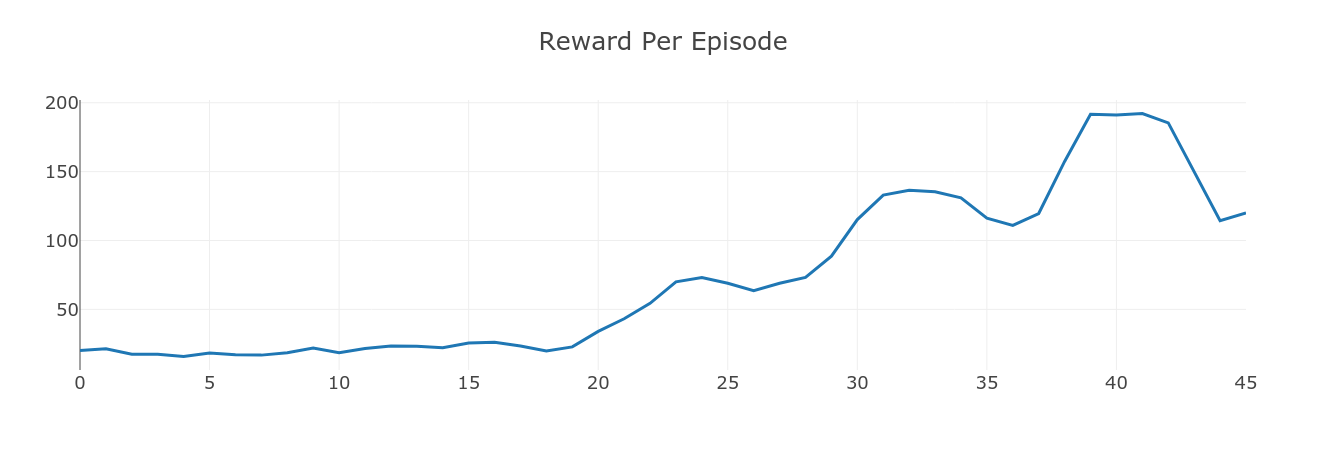

In [37]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

plotly.offline.iplot({
    "data": [go.Scatter(x=np.arange(len(ep_rewards)), y=moving_average(ep_rewards, 5))],
    "layout": go.Layout(title="Reward Per Episode", template="presentation")
})